In [1]:
import time
import pickle
import os

import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from langdetect import detect, DetectorFactory
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from datasets import Dataset, load_dataset, DatasetDict
from transformers import TFAutoModel, AutoTokenizer
import joblib

In [2]:
# load dataset
dataset_all = load_dataset("csv", data_files="reviews.csv.gz")
dataset_all # check features and number of rows

DatasetDict({
    train: Dataset({
        features: ['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'],
        num_rows: 458700
    })
})

In [3]:
dataset_all["train"][:5] # check head of dataset

{'listing_id': [290701, 290701, 290701, 290701, 290701],
 'id': [932562, 957677, 996773, 1157773, 1220739],
 'date': ['2012-02-20',
  '2012-02-28',
  '2012-03-13',
  '2012-04-21',
  '2012-05-03'],
 'reviewer_id': [734131, 1773124, 1647365, 1367158, 1392171],
 'reviewer_name': ['Diane', 'Olivier', 'Adam', 'Janine', 'Andrea'],
 'comments': ["To stay at David's home was a perfect time. The house is located near the central railway station alongside a beautiful canal and very quiet. Thanks for all David !",
  "My first AirBnb experience. Really neat ! The room was just as described : large, beautiful, clean, modern. It felt like it was brand new. There was absolutely no noise, even on week end days, and yet the room is in the best location we could hope for. David's friend warmly welcomed us, and was available on the phone if needed.\r<br/>We highly recommend this place.",
  'David was a great host.  His apartment is very nice: comfortable bed, fast internet, and a nice bathroom.  It is al

In [4]:
# detects language of a comment
DetectorFactory.seed = 42

def detect_language(comment):
    try:
        return detect(comment)
    except:
        return "unknown"

In [5]:
# processing dataset

# changing format to dataframe
dataset_all.set_format(type="pandas")

df = dataset_all["train"]

# dropping comments that are empty
df = df.dropna(subset=['comments']) 

# detecting languages of comments and filtering only english ones- then deleting column language
df["language"] = df["comments"].apply(detect_language) 
df = df[df["language"] == "en"]
del df['language']

In [11]:
# creating sentiment to train our model with interpreter Vader https://medium.com/@rslavanyageetha/vader-a-comprehensive-guide-to-sentiment-analysis-in-python-c4f1868b0d2e
def analyse(text):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    
    # Interpret based on compound score
    if scores['compound'] > 0:
        sentiment = 1
    elif scores['compound'] <= 0:
        sentiment = 0
    return sentiment

In [13]:
df['sentiment'] = df['comments'].apply(analyse)
df

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentiment
0,290701,932562,2012-02-20,734131,Diane,To stay at David's home was a perfect time. Th...,1
1,290701,957677,2012-02-28,1773124,Olivier,My first AirBnb experience. Really neat ! The ...,1
2,290701,996773,2012-03-13,1647365,Adam,David was a great host. His apartment is very...,1
3,290701,1157773,2012-04-21,1367158,Janine,Our first bnb experience. It was perfect. Clea...,1
4,290701,1220739,2012-05-03,1392171,Andrea,Excellent from every point of view.\r<br/>Loca...,1
6,290701,1299929,2012-05-18,1881402,Megan,Where do I start? My friend and I got to Amste...,1
8,290701,1554536,2012-06-25,2129669,Caroline,Your stay in Amsterdam was amazing!!\r<br/>The...,1
9,290701,1954704,2012-08-12,2330546,James,Super location. 5 minutes to central station....,1


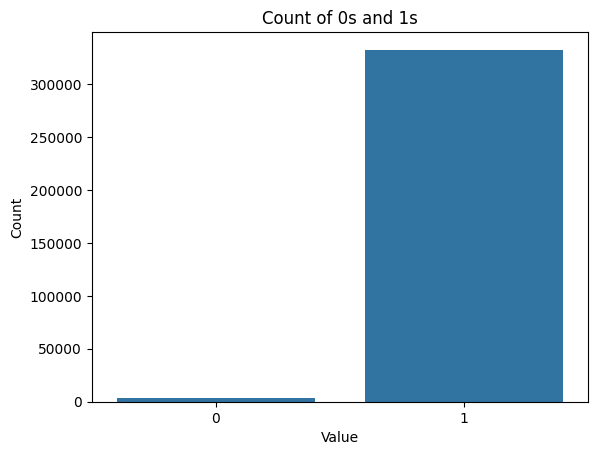

sentiment
1    332457
0      3127
Name: count, dtype: int64

In [24]:
sns.countplot(x=df['sentiment'])
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Count of 0s and 1s')
plt.show()
counts = df['sentiment'].value_counts()
counts

In [26]:
# undersampling - keeping only a random sample of class 1, the same n as class 0
df = df.groupby('sentiment').apply(lambda x: x.sample(n=len(df[df['sentiment'] == 0]), random_state=42)).reset_index(drop=True)

print(df['sentiment'].value_counts())

sentiment
0    3127
1    3127
Name: count, dtype: int64


C:\Users\sitko\AppData\Local\Temp\ipykernel_12040\215344700.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('sentiment').apply(lambda x: x.sample(n=len(df[df['sentiment'] == 0]), random_state=42)).reset_index(drop=True)


In [28]:
# df containing only two columns and only a sample of 1000
df_1000 = df[['comments', 'sentiment']].sample(1000, random_state=42)

# changing format back to dataset
dataset = Dataset.from_pandas(df_1000)

In [30]:
# split into train/test/validation datasets
train_test_split = dataset.train_test_split(test_size=0.2, seed=42, shuffle=True)
train_valid_split = train_test_split["test"].train_test_split(test_size=0.5, seed=42, shuffle=True)

dataset = DatasetDict({
    "train": train_test_split["train"],
    "validation": train_valid_split["train"],
    "test": train_valid_split["test"]
})

# check dataset sizes
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['comments', 'sentiment', '__index_level_0__'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['comments', 'sentiment', '__index_level_0__'],
        num_rows: 100
    })
    test: Dataset({
        features: ['comments', 'sentiment', '__index_level_0__'],
        num_rows: 100
    })
})


In [35]:
# choosing a llm model
model = "distilbert-base-uncased"

# model distilbert in tensorflow and matching tokenizer
tf_model = TFAutoModel.from_pretrained(model)
tokenizer = AutoTokenizer.from_pretrained(model)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [33]:
# tokenizing and returning last hidden states vector
def extract_hidden_states(batch):
    # convert text to tokens
    inputs = tokenizer(batch["comments"], padding=True, 
                       truncation=True, return_tensors='tf')
    # extract last hidden states
    outputs = tf_model(inputs)
     # return vector for cls token
    return {"hidden_state": outputs.last_hidden_state[:,0].numpy()}

dataset_hidden = dataset.map(extract_hidden_states, batched=True, batch_size=64)

C:\Users\sitko\anaconda3\envs\transformer\Lib\site-packages\transformers\generation\tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [36]:
dataset_hidden

DatasetDict({
    train: Dataset({
        features: ['comments', 'sentiment', '__index_level_0__', 'hidden_state'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['comments', 'sentiment', '__index_level_0__', 'hidden_state'],
        num_rows: 100
    })
    test: Dataset({
        features: ['comments', 'sentiment', '__index_level_0__', 'hidden_state'],
        num_rows: 100
    })
})

In [38]:
# creating train data
X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["validation"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["sentiment"])
y_valid = np.array(dataset_hidden["validation"]["sentiment"])
X_train.shape, X_valid.shape

((800, 768), (100, 768))

In [40]:
# training classification model
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [42]:
y_preds = lr_clf.predict(X_valid)  # generating predictions
lr_clf.score(X_valid, y_valid) # counting accuracy
print(lr_clf.score(X_valid, y_valid))

0.98


In [61]:
# saving model
joblib.dump(lr_clf, 'my_model.pkl')

['my_model.pkl']

In [48]:
# dataset to df
df_eval = pd.DataFrame({'y_true': y_valid, 'y_preds': y_preds})

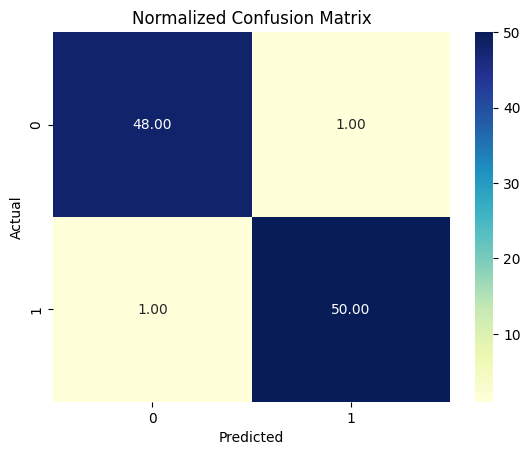

(Text(0.5, 1.0, 'Normalized Confusion Matrix'), None)

In [50]:
# plot matrix
cm = confusion_matrix(df_eval['y_true'], df_eval['y_preds'])
labels = np.unique(df_eval['y_true'])
sns.heatmap(cm, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted"), plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix"), plt.show()

In [52]:
# function predicting one comment
def predict (comment):
    # tokenizer
    inputs = tokenizer(comment, padding=True, truncation=True, return_tensors='tf')
    # last hidden states
    outputs = tf_model(inputs)
     # vector
    vector = outputs.last_hidden_state[:,0].numpy() 
    # predict
    lr_clf = joblib.load('my_model.pkl')
    sentiment = lr_clf.predict(vector)
    # interpretation
    if sentiment == 0:
        return "Negative"
    elif sentiment == 1:
        return "Positive"

In [54]:
predict('very cool') 

'Positive'

In [56]:
predict('very uncool')

'Negative'